In [112]:
import numpy as np
from numpy import linalg as LA
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
from scipy.interpolate import interp1d
import pandas as pd
from scipy.special import jv
from scipy.linalg import solve_sylvester

def log_transform(im):
    '''returns log(image) scaled to have the sam max and min'''
    try:
        (min, max) = (im.min(), im.max())
        return max*(np.log(im) - np.log(min)) / (np.log(max) - np.log(min))
    except:
        pass
    return im

def get_square_H(s,skin_depth,resolution,H0=1):
    k = (1-1j)/skin_depth
    dx = s/resolution #stepsize: x direction
    beta_x = 1/dx**2 #avoid repeated operations
    alpha_x = -2*beta_x+k**2/2
    Xmat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize A matrix
    # Ymat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize B matrix
    # corners
    Xmat[0][0] = alpha_x
    Xmat[resolution-1][resolution-1] = alpha_x

    #interior
    for i in range(1,resolution-1):
        Xmat[i][i]= alpha_x #alpha_x

        Xmat[i][i+1]= beta_x #beta_x
        Xmat[i][i-1]= beta_x #beta_x
        #this set the points to the right and left of the diagonal

    #remaining two exterior points
    Xmat[0][1] = beta_x
    Xmat[resolution-1][resolution-2] = beta_x

    C = np.zeros([resolution,resolution],dtype=np.complex_) #boundary conditions (The 
    #component of H parallel to the surface of the conductor is continuous 
    #provided there are no free surface currents.) 

    H_beta_x = -H0*beta_x

    C[0][0] = 2*H_beta_x
    C[resolution-1][0] = 2*H_beta_x
    C[0][resolution-1] = 2*H_beta_x
    C[resolution-1][resolution-1] = 2*H_beta_x

    for i in range(1,resolution-1):
        C[0][i] = H_beta_x
        C[resolution-1][i] = H_beta_x
        C[i][0] = H_beta_x
        C[i][resolution-1] = H_beta_x
        
    X = solve_sylvester(Xmat,Xmat,C)
    
    for i in range(resolution):
        for j in range(resolution):
            if X[i][j].real > 1:
                print("Error at position ",i,", ",j) #It is unphysical for the 
                #field to be larger in magnitude within the conductor than outside of it 
                #(provided that it is not magnetic).
    # print(X-solve_sylvester(Xmat,Xmat,C))             
    NewX= np.zeros([resolution+2,resolution+2],dtype=np.complex_) 
    for i in range(resolution+2): #This for loop defines the field at the surface 
        #of the conductor (It must be H0).
        
        for j in range(resolution+2):
            if ((i ==0) or (i==(resolution+1)) or (j ==0) or (j==(resolution+1))):
                NewX[i][j] =H0 
            else:
                NewX[i][j]=X[i-1][j-1]
    return NewX


def get_cylind_H(d,skin_depth,resolution,H0=1):
    k = (1-1j)/skin_depth
    cylindH = H0 * np.ones([resolution+2,resolution+2],dtype=np.complex_)
    for i in range(resolution+2):
        for j in range(resolution+2):
            r = np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)/(resolution+1)*d
            if r<=d/2:
                # print(np.sqrt((i-(resolution+2)/2)**2 + (j-(resolution+2)/2)**2)/(resolution+2),end='')
                cylindH[i][j] = jv(0,r*k)/jv(0,d/2*k)
    return cylindH

def get_shape_H_old(shape_data,s,skin_depth,resolution,H0=1):
    k=(1-1j)/skin_depth #k value 
    
    #This analysis is only useful if there are many more divisions per unit length than the inverse of 
    #the skin depth (Otherwise, valuable information is missed). This is 
    #the reason for increasing the resolution at small skin depths: div 
    #is res by default but becomes larger if the skin depth is sufficiently small.
    
    dx = s/(resolution) #stepsize: x direction
    # Because the input matrix shape_data must be square, dx=dy

    """This analysis solves the differential equation del^2(H)+k^2*H=0 over 
    an arbitary shaped sample. A second order approximation for H is used, which 
    is appropriate given the presence of the Laplacian."""

    k = (1-1j)/skin_depth
    dx = s/resolution #stepsize: x direction
    beta_x = 1/dx**2 #avoid repeated operations
    alpha_x = -2*beta_x+k**2/2
    # dy = s/resolution #stepsize: y direction
    Xmat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize A matrix
    print(np.absolute(k**2),beta_x)

    # corners
    Xmat[0][0] = alpha_x
    Xmat[resolution-1][resolution-1] = alpha_x

    #interior
    for i in range(1,resolution-1):
        Xmat[i][i]= alpha_x #alpha_x

        Xmat[i][i+1]= beta_x #beta_x
        Xmat[i][i-1]= beta_x #beta_x
        #this set the points to the right and left of the diagonal

    #remaining two exterior points
    Xmat[0][1] = beta_x
    Xmat[resolution-1][resolution-2] = beta_x

    C = np.zeros([resolution,resolution],dtype=np.complex_) #boundary conditions (The 
    #component of H parallel to the surface of the conductor is continuous 
    #provided there are no free surface currents.) 
    
    H_beta_x = -H0*beta_x
    k2 = k**2

    #corners
    if not(shape_data[0][0]):
        C[0][0] = 2*H_beta_x + k2
    else:
        C[0][0] = 2*H_beta_x
    if not(shape_data[resolution-1][0]):
        C[resolution-1][0] = 2*H_beta_x + k2
    else:
        C[resolution-1][0] = 2*H_beta_x
    if not(shape_data[0][resolution-1]):
        C[0][resolution-1] = 2*H_beta_x + k2
    else:
        C[0][resolution-1] = 2*H_beta_x
    if not(shape_data[resolution-1][resolution-1]):
        C[resolution-1][resolution-1] = 2*H_beta_x + k2
    else:
        C[resolution-1][resolution-1] = 2*H_beta_x
    

    #edges
    for i in range(1,resolution-1):
        if not(shape_data[0][i]):
            C[0][i] = H_beta_x + k2
        else:
            C[0][i] = H_beta_x
        if not(shape_data[resolution-1][i]):
            C[resolution-1][i] = H_beta_x + k2
        else:
            C[resolution-1][i] = H_beta_x
        if not(shape_data[i][0]):
            C[i][0] = H_beta_x + k2
        else:
            C[i][0] = H_beta_x
        if not(shape_data[i][resolution-1]):
            C[i][resolution-1] = H_beta_x + k2
        else:
            C[i][resolution-1] = H_beta_x
        
    #interior
    for i in range(1,resolution-1):
        for j in range(1,resolution-1):
            if shape_data[i][j]:
                C[i][j] = k2
    # print(Xmat,C)

    X = solve_sylvester(Xmat,Xmat,C)
                
    NewX= np.zeros([resolution+2,resolution+2],dtype=np.complex_) 
    for i in range(resolution+2): #This for loop defines the field at the surface 
        #of the conductor (It must be H0).
        
        for j in range(resolution+2):
            if ((i ==0) or (i==(resolution+1)) or (j ==0) or (j==(resolution+1))):
                NewX[i][j] =H0 
            else:
                NewX[i][j]=X[i-1][j-1]
    return NewX

def get_shape_H(mask,s,skin_depth,resolution,iterations,H0=1):
    k_squared = ((1 - 1j) / skin_depth)**2  # complex number
    k = (1 - 1j) / skin_depth

    x = np.linspace(0, s, resolution)  # x-axis points
    dx = x[1] - x[0]  # grid spacing in x

    # Define the initial condition
    z = np.ones((resolution, resolution), dtype=np.complex128)  # initial solution matrix
    # shape_inds = np.array([])
    for i in range(1, resolution - 1):  # loop over the interior points in x
        for j in range(1, resolution - 1):  # loop over the interior points in y
            if mask[i, j] == 0:
                r = np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)/(resolution+1)*s
                z[i,j] = jv(0,r*k)/jv(0,s/2*k)
                # shape_inds = np.append(shape_inds,(i,j))


    # Time to iterate
    for n in range(iterations):
        # for m in range(len(shape_inds)//2):
        #     i = int(shape_inds[2*m])
        #     j = int(shape_inds[2*m+1])
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 0:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) / (4 - k_squared * dx**2)
    return z

def get_skin_depth(rho,frequency=671111):
    return (2*rho/(4e-7*np.pi*2 * np.pi *frequency))**.5

def adjustsize(data, start,end,resolution):
    if end < start:
        return data
    n = int(end/start*resolution) #new matrix size
    starting_ind = int(resolution*(end/start-1)/2)
    output = np.ones([n,n],dtype=np.complex_)
    for i in range(resolution+2):# assuming the matrix has an outside row of 1s, so its size is resolution +2
        for j in range(resolution+2):
            output[starting_ind + i - 1][starting_ind + j - 1] = data[i][j]
    return output

Text(0.5, 1.0, '1 mm$^2$ Copper Triangle Cross Section')

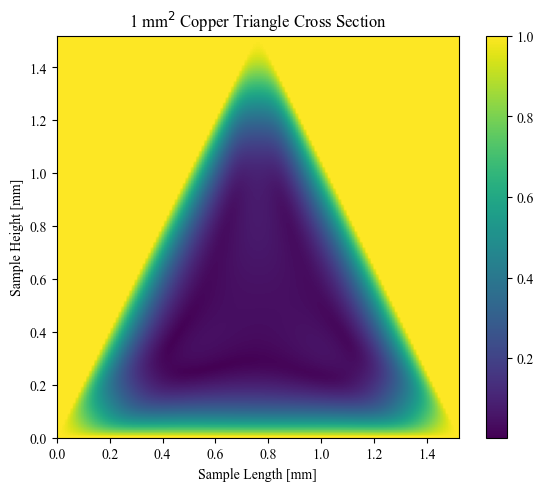

In [113]:
tri_resolution = 150
iter = 500
l = 2*3**(-.25)*1e-3 #this is the legnth of all the sides of triangle. This will gave an area of 1mm^2
tri_data = np.ones([tri_resolution,tri_resolution])
for i in range(tri_resolution):
    for j in range(tri_resolution):
        if i>=2*abs(j-(tri_resolution-1)/2):# or i<=2*abs(j-(tri_resolution-1)/2):
            tri_data[i][j] = 0

# print(tri_data)

tri_H = get_shape_H(tri_data,l,get_skin_depth(2e-8),tri_resolution,iter)
# tri_H = get_shape_H(np.zeros([tri_resolution,tri_resolution]),l,get_skin_depth(2e-6),tri_resolution)

fig = plt.figure(constrained_layout = True)
ax = fig.add_subplot(1, 1, 1)

p1 = ax.imshow(np.absolute(tri_H ),extent=[0, l*1e3, 0, l*1e3])#,norm=colors.LogNorm(vmin=min(np.absolute(tri_H )), vmax=1))
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length [mm]')
ax.set_ylabel('Sample Height [mm]')
ax.set_title(r'1 mm$^2$ Copper Triangle Cross Section')

In [62]:
tri_resolution = 9
l = 2*3**(-.25)*1e-3 #this is the legnth of all the sides of triangle. This will gave an area of 1mm^2
# tri_data = np.zeros([tri_resolution,tri_resolution])
tri_H = get_square_H(l,get_skin_depth(2e-8),tri_resolution)

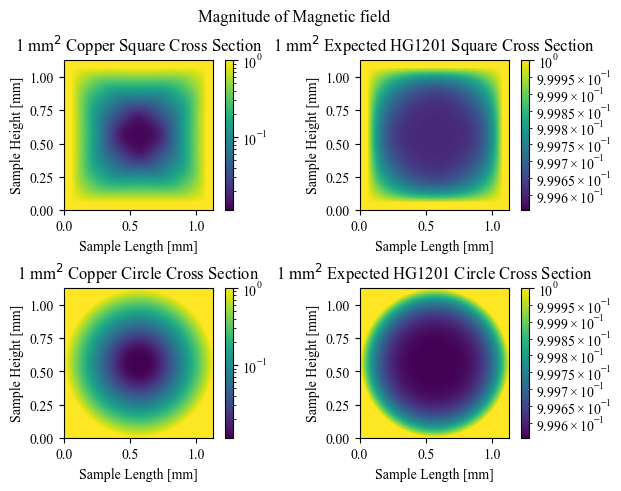

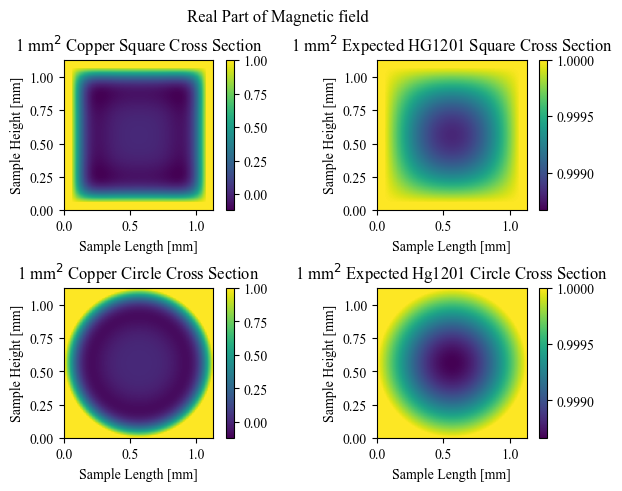

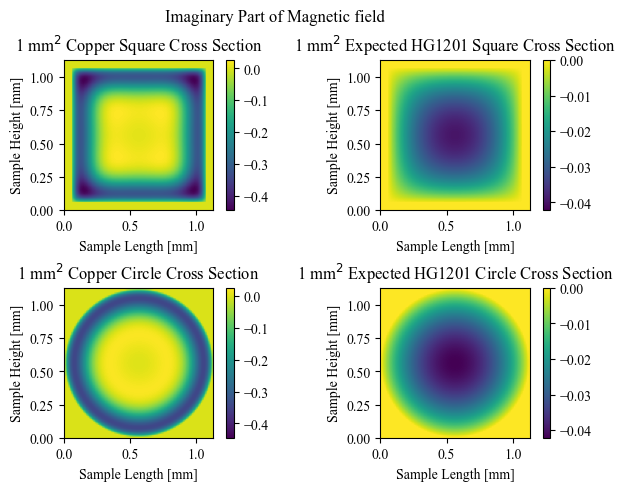

In [65]:
#################################
# Geometry Effects Plotting
#################################

cylind_resolution = 100
square_resolution = 100
s = 1e-3 # length in meters
d = 2e-3/np.pi**.5 #diameter in meters

rho = np.array([2e-8,1000e-8]) #resistivities in ohm*m
skin_depths = get_skin_depth(rho)
CopperSquare = get_square_H(s,skin_depths[0],square_resolution)
CopperCylind = get_cylind_H(d,skin_depths[0],cylind_resolution)
InsolSquare = get_square_H(s,skin_depths[1],square_resolution)
InsolCylind = get_cylind_H(d,skin_depths[1],cylind_resolution)

CopperSquare = adjustsize(CopperSquare,1,2/np.pi**.5,square_resolution)
InsolSquare = adjustsize(InsolSquare,1,2/np.pi**.5,square_resolution)

coppermin = min(np.absolute(CopperSquare).min(),np.absolute(CopperCylind).min())
insolmin = min(np.absolute(InsolSquare).min(),np.absolute(InsolCylind).min())

fig = plt.figure(constrained_layout = True)
ax = fig.add_subplot(2, 2, 1)
fig.suptitle('Magnitude of Magnetic field')
bx = fig.add_subplot(2, 2, 2)
cx = fig.add_subplot(2, 2, 3)
dx = fig.add_subplot(2, 2, 4)

p1 = ax.imshow(np.absolute(CopperSquare),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length [mm]')
ax.set_ylabel('Sample Height [mm]')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')

p2 = bx.imshow(np.absolute(InsolSquare),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=insolmin, vmax=1))
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length [mm]')
bx.set_ylabel('Sample Height [mm]')
bx.set_title(r'1 mm$^2$ Expected HG1201 Square Cross Section')

p3 = cx.imshow(np.absolute(CopperCylind),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length [mm]')
cx.set_ylabel('Sample Height [mm]')
cx.set_title(r'1 mm$^2$ Copper Circle Cross Section')

p4 = dx.imshow(np.absolute(InsolCylind),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=insolmin, vmax=1))
fig.colorbar(p4, ax=dx)
dx.set_xlabel('Sample Length [mm]')
dx.set_ylabel('Sample Height [mm]')
dx.set_title(r'1 mm$^2$ Expected HG1201 Circle Cross Section')
plt.show()

coppermin = min(np.real(CopperSquare).min(),np.real(CopperCylind).min())
insolmin = min(np.real(InsolSquare).min(),np.real(InsolCylind).min())
coppermax = max(np.real(CopperSquare).max(),np.real(CopperCylind).max())
insolmax = min(np.real(InsolSquare).max(),np.real(InsolCylind).max())

fig = plt.figure(constrained_layout = True)
fig.suptitle('Real Part of Magnetic field')
ax = fig.add_subplot(2, 2, 1)
bx = fig.add_subplot(2, 2, 2)
cx = fig.add_subplot(2, 2, 3)
dx = fig.add_subplot(2, 2, 4)

p1 = ax.imshow(np.real(CopperSquare),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length [mm]')
ax.set_ylabel('Sample Height [mm]')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')

p2 = bx.imshow(np.real(InsolSquare),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length [mm]')
bx.set_ylabel('Sample Height [mm]')
bx.set_title(r'1 mm$^2$ Expected HG1201 Square Cross Section')

p3 = cx.imshow(np.real(CopperCylind),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length [mm]')
cx.set_ylabel('Sample Height [mm]')
cx.set_title(r'1 mm$^2$ Copper Circle Cross Section')

p4 = dx.imshow(np.real(InsolCylind),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p4, ax=dx)
dx.set_xlabel('Sample Length [mm]')
dx.set_ylabel('Sample Height [mm]')
dx.set_title(r'1 mm$^2$ Expected Hg1201 Circle Cross Section')
plt.show()

coppermin = min(np.imag(CopperSquare).min(),np.imag(CopperCylind).min())
insolmin = min(np.imag(InsolSquare).min(),np.imag(InsolCylind).min())
coppermax  = max(np.imag(CopperSquare).max(),np.imag(CopperCylind).max())
insolmax = max(np.imag(InsolSquare).max(),np.imag(InsolCylind).max())

fig = plt.figure(constrained_layout = True)
fig.suptitle('Imaginary Part of Magnetic field')
ax = fig.add_subplot(2, 2, 1)
bx = fig.add_subplot(2, 2, 2)
cx = fig.add_subplot(2, 2, 3)
dx = fig.add_subplot(2, 2, 4)

p1 = ax.imshow(np.imag(CopperSquare),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length [mm]')
ax.set_ylabel('Sample Height [mm]')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')

p2 = bx.imshow(np.imag(InsolSquare),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length [mm]')
bx.set_ylabel('Sample Height [mm]')
bx.set_title(r'1 mm$^2$ Expected HG1201 Square Cross Section')

p3 = cx.imshow(np.imag(CopperCylind),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length [mm]')
cx.set_ylabel('Sample Height [mm]')
cx.set_title(r'1 mm$^2$ Copper Circle Cross Section')

p4 = dx.imshow(np.imag(InsolCylind),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p4, ax=dx)
dx.set_xlabel('Sample Length [mm]')
dx.set_ylabel('Sample Height [mm]')
dx.set_title(r'1 mm$^2$ Expected HG1201 Circle Cross Section')
plt.show()

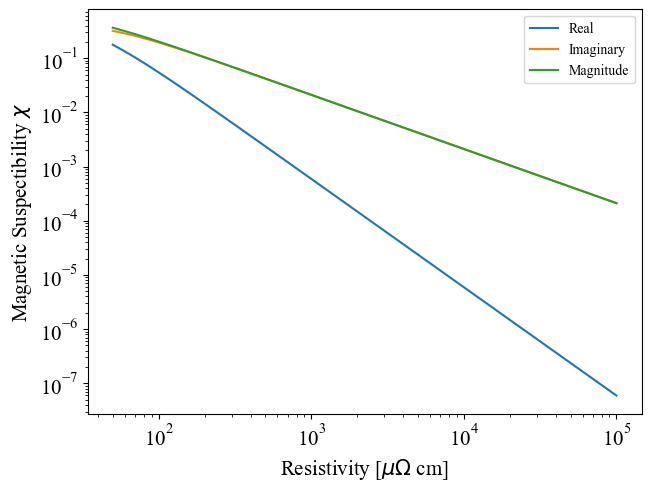

In [42]:
########################################
# Magnetic Susecptibility v Resistivity
########################################

rhos = np.linspace(50e-8,1e-3,100000)
chis = np.zeros(len(rhos),dtype=np.complex_) #Stores the effective magnetic susceptibility of circle
chis2 = np.zeros(len(rhos),dtype=np.complex_)
s = 1e-3 # length in meters
d = 2e-3/np.pi**.5 #diameter in meters
a=d/2 #radius

resolution = 100
H0 = 1
for i, rho in enumerate(rhos):
    k= (1-1j)/get_skin_depth(rho)
    chis[i]=jv(2,a*k)/jv(0,a*k)
    # Square = get_square_H(s,get_skin_depth(rho),resolution)
    # summ = 0
    # for i in range(1,resolution+1):
    #     for j in range(1,resolution+1):
    #         summ += (Square[i][j]+Square[i+1][j]+Square[i][j+1]+Square[i+1][j+1])*(s/(resolution))**2/4 #Numerical 
    #         #integration of H*da
    # chis2[i]=summ/(H0*1e-6)-1

fig = plt.figure(constrained_layout = True)#, figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1)
# bx = fig.add_subplot(2, 1, 2)
ax.plot(rhos*1e8,abs(chis.real))
ax.plot(rhos*1e8,abs(chis.imag))
ax.plot(rhos*1e8,np.absolute(chis))
ax.set_xlabel(r"Resistivity [$\mu \Omega$ cm]",fontsize=15)
ax.set_ylabel(r"Magnetic Suspectibility $\chi$",fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([min(rhos),max(rhos)])
# ax.set_ylim([0,max(-chis.real)])
ax.legend(['Real','Imaginary','Magnitude'])

# bx.plot(rhos*1e8,abs(chis2.real))
# bx.plot(rhos*1e8,abs(chis2.imag))
# bx.plot(rhos*1e8,np.absolute(chis2))
# bx.set_xlabel(r"Resistivity [$\mu \Omega$ cm]",fontsize=15)
# bx.set_ylabel(r"Magnetic Suspectibility $\chi$",fontsize=15)
# bx.tick_params(axis='x', labelsize=15)
# bx.tick_params(axis='y', labelsize=15)
# bx.set_xscale('log')
# bx.set_yscale('log')
# # bx.set_xlim([min(rhos),max(rhos)])
# # bx.set_ylim([0,max(-chis.real)])
# bx.legend(['Real','Imaginary','Magnitude'])



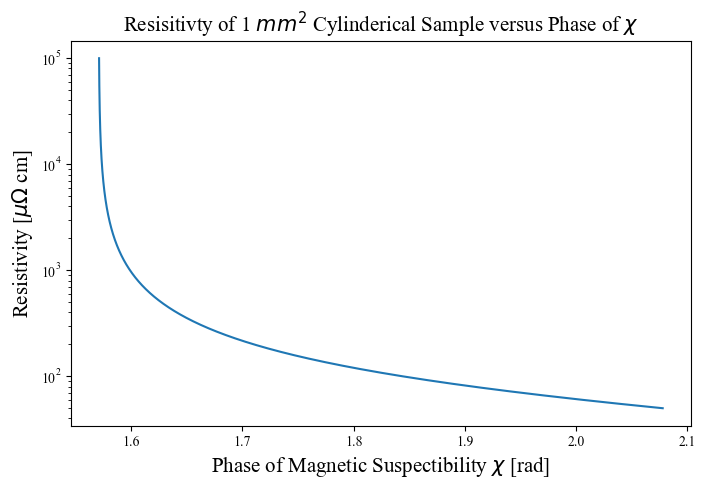

In [41]:

fig,cx = plt.subplots(1,1,figsize = (8,5))
# bx = fig.add_subplot(2, 1, 2)
cx.plot(abs(np.angle(chis)),rhos*1e8)
cx.set_ylabel(r"Resistivity [$\mu \Omega$ cm]",fontsize=15)
cx.set_xlabel(r"Phase of Magnetic Suspectibility $\chi$ [rad]",fontsize=15)
cx.set_title(r'Resisitivty of 1 $mm^2$ Cylinderical Sample versus Phase of $\chi$',fontsize=15)
# cx.tick_params(axis='x', labelsize=15)
# cx.tick_params(axis='y', labelsize=15)
# cx.set_xscale('log')
cx.set_yscale('log')
# cx.set_xticks(np.arange(min(abs(np.angle(chis))), max(abs(np.angle(chis))), step=0.2))
# ax.set_xlim([min(rhos),max(rhos)])
# ax.set_ylim([0,max(-chis.real)])
# ax.legend(['Real','Imaginary','Magnitude'])

In [ ]:

"""Run the top above code cell before running this one."""
import matplotlib.colors as mcolors
f=671111 #Frequency in Hz
phase = np.zeros(len(chis))
for i in range(len(chis)):
    phase[i] = np.angle(chis[i])
    
F=interp1d(phase,d) #Interpolate the data from the plot above such that a phase can
#be mapped to the corresponding X value.

# filepath = '/Users/jackzwettler/Documents/2021_3_c.xlsx' #This is the file that contains
#the data from the probe.

filepath = '/Users/blake/Documents/ContactlessProbeData/2021_3_c.xlsx'

probe_dat = pd.read_excel(filepath) #Retrieve data

Xdat = probe_dat.to_numpy() 

low = 3400 #This is the excel row entry when the warming stage begins.
high = 8847 #This is the excel row entry when the warming stage ends.

RT = np.zeros(high-low+1) #Temperature data for this iteration only
RP = np.zeros(high-low+1) #phase data for this iteration only
    
p_off = 0.241 #This phase offset is due to the steel tube, and it is evident in the
#output from a superconducting sample. Specifically, the phase of the output should be 
#zero for a superconductor because chi= -1. However, it is observed that Im(chi) != 0.
        
for i in range(high-2,low-3,-1):
    RT[i-low+2]=Xdat[i][0] #T (K)
    RP[i-low+2]=Xdat[i][6] #Phase (rad). This can be achieved using the "ATAN"
    #function in excel or in python with numpy's "arctan" function.
    
    #Also note that Xdat is 0 indexed, i.e. the first column of an excel file is 
    #stored in Xdat[i][0].
    
    if (RP[i-low+2]> 0):
        RP[i-low+2] -= np.pi+p_off #Unwrap
    else:
        RP[i-low+2] -= p_off
    
Rho = np.zeros(len(RP)) 
skin = np.zeros(len(RP)) 
test = np.zeros(len(RP)) 
color = np.zeros(len(RP))
colors=['red','green','blue']
for i in range(high-2,low-3,-1):
    if (RP[i-low+2]>= max(phase)):
        Rho[i-low+2] = 10000 #This value is meaningless, something went wrong here
        color[i-low+2]=1 
    elif (RP[i-low+2]<= min(phase)): 
        Rho[i-low+2] = 0 #This value is (possibly) meaningless, but it might just be superconducting   
        color[i-low+2]=2
    else:
        skin[i-low+2] = math.sqrt(a*b/F(RP[i-low+2]))/1000
        test[i-low+2]=F(RP[i-low+2])
        Rho[i-low+2] = (np.pi**2*f*40)*skin[i-low+2]**2
        color[i-low+2]=3
    
fig,bx = plt.subplots(1, 1, figsize=(6, 4))
cmap, norm = mcolors.from_levels_and_colors([0, 1.5, 2.5, 3.5], ['red', 'green', 'blue']) 
bx.scatter(RT,RP,s=1,c=color,cmap=cmap,norm=norm)
bx.tick_params(axis='x', labelsize=15)
bx.tick_params(axis='y', labelsize=15)
bx.set_xlabel('Temperature (K)',fontsize = 15)
bx.set_ylabel('Phase (rad)',fontsize = 15)
bx.grid()

#Red: Data is above the interpolation range (Signal might be too weak or data wasn't 
#processed properly.)
#Blue: Data is within the interpolation range
#Green: Data is below the interpolation range (Superconducting?)

#The variable rho holds the resistivity, and can be plotted in a similar fashion.




In [1]:
# Chat GPT second try

import numpy as np
import matplotlib.pyplot as plt


# Define the parameters
rho = 2.0e-6  # resistivity
k_squared = (1 - 1j) / get_skin_depth(rho)  # complex number
print(k_squared)

# Define the domain
xmin, xmax, nx = 0, 1, 200
ymin, ymax, ny = 0, 1, 200
x = np.linspace(xmin, xmax, nx)  # x-axis points
y = np.linspace(ymin, ymax, ny)  # y-axis points
dx = x[1] - x[0]  # grid spacing in x
dy = y[1] - y[0]  # grid spacing in y

# Define the initial condition
z0 = np.ones((nx, ny), dtype=np.complex128)  # initial solution matrix

# Set the boundary conditions
mask = np.zeros((nx, ny))  # initialize the mask to zeros
x0, y0, r = 0.5, 0.5, 0.5  # define the center and radius of the circle
for i in range(nx):
    for j in range(ny):
        if (x[i] - x0)**2 + (y[j] - y0)**2 > r**2:
            mask[i, j] = 1  # set the mask to 1 at the boundary points

# Define the iteration function
def iterate(z0, dx, dy, k_squared, mask):
    #z = z0.copy()  # make a copy of the current solution matrix
    nx, ny = z.shape  # get the shape of the matrix
    for i in range(1, nx - 1):  # loop over the interior points in x
        for j in range(1, ny - 1):  # loop over the interior points in y
            if mask[i, j] == 0:  # check if the current point is in the interior
                # update the current point using the finite difference method
                z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) / (4 - k_squared * dx**2)

    return z

# Solve the equation using the finite difference method
z = z0.copy()  # initialize the solution matrix


for n in range(1000):  # number of iterations
    z = iterate(z, dx, dy, k_squared, mask)  # iterate the solution

analytic = get_cylind_H(1,rho,nx-2)

# Plot the solution
fig, ax = plt.subplots()
p = ax.imshow((np.absolute(z)-np.absolute(analytic))/np.absolute(analytic),extent=[0, 1, 0, 1])
fig.colorbar(p, ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Solution to the PDE')
plt.show()



NameError: name 'get_skin_depth' is not defined